In [1]:
import pandas as pd
from prophet import Prophet

In [2]:
def warm_start_params(m):
    """
    Retrieve parameters from a trained model in the format used to initialize a new Stan model.
    Note that the new Stan model must have these same settings:
        n_changepoints, seasonality features, mcmc sampling
    for the retrieved parameters to be valid for the new model.

    Parameters
    ----------
    m: A trained model of the Prophet class.

    Returns
    -------
    A Dictionary containing retrieved parameters of m.
    """
    res = {}
    for pname in ['k', 'm', 'sigma_obs']:
        if m.mcmc_samples == 0:
            res[pname] = m.params[pname][0][0]
        else:
            res[pname] = np.mean(m.params[pname])
    for pname in ['delta', 'beta']:
        if m.mcmc_samples == 0:
            res[pname] = m.params[pname][0]
        else:
            res[pname] = np.mean(m.params[pname], axis=0)
    return res

df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df1 = df.loc[df['ds'] < '2016-01-19', :]  # All data except the last day
m1 = Prophet().fit(df1) # A model fit to all data except the last day


%timeit m2 = Prophet().fit(df)  # Adding the last day, fitting from scratch
%timeit m2 = Prophet().fit(df, init=warm_start_params(m1))  # Adding the last day, warm-starting from m1

17:03:41 - cmdstanpy - INFO - Chain [1] start processing
17:03:41 - cmdstanpy - INFO - Chain [1] done processing
17:03:41 - cmdstanpy - INFO - Chain [1] start processing
17:03:41 - cmdstanpy - INFO - Chain [1] done processing
17:03:41 - cmdstanpy - INFO - Chain [1] start processing
17:03:42 - cmdstanpy - INFO - Chain [1] done processing
17:03:42 - cmdstanpy - INFO - Chain [1] start processing
17:03:42 - cmdstanpy - INFO - Chain [1] done processing
17:03:42 - cmdstanpy - INFO - Chain [1] start processing
17:03:42 - cmdstanpy - INFO - Chain [1] done processing
17:03:43 - cmdstanpy - INFO - Chain [1] start processing
17:03:43 - cmdstanpy - INFO - Chain [1] done processing
17:03:43 - cmdstanpy - INFO - Chain [1] start processing
17:03:43 - cmdstanpy - INFO - Chain [1] done processing
17:03:43 - cmdstanpy - INFO - Chain [1] start processing
17:03:43 - cmdstanpy - INFO - Chain [1] done processing
17:03:44 - cmdstanpy - INFO - Chain [1] start processing
17:03:44 - cmdstanpy - INFO - Chain [1]

345 ms ± 7.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


17:03:44 - cmdstanpy - INFO - Chain [1] start processing
17:03:44 - cmdstanpy - INFO - Chain [1] done processing
17:03:44 - cmdstanpy - INFO - Chain [1] start processing
17:03:44 - cmdstanpy - INFO - Chain [1] done processing
17:03:44 - cmdstanpy - INFO - Chain [1] start processing
17:03:45 - cmdstanpy - INFO - Chain [1] done processing
17:03:45 - cmdstanpy - INFO - Chain [1] start processing
17:03:45 - cmdstanpy - INFO - Chain [1] done processing
17:03:45 - cmdstanpy - INFO - Chain [1] start processing
17:03:45 - cmdstanpy - INFO - Chain [1] done processing
17:03:45 - cmdstanpy - INFO - Chain [1] start processing
17:03:45 - cmdstanpy - INFO - Chain [1] done processing
17:03:45 - cmdstanpy - INFO - Chain [1] start processing
17:03:45 - cmdstanpy - INFO - Chain [1] done processing
17:03:45 - cmdstanpy - INFO - Chain [1] start processing
17:03:45 - cmdstanpy - INFO - Chain [1] done processing
17:03:45 - cmdstanpy - INFO - Chain [1] start processing
17:03:46 - cmdstanpy - INFO - Chain [1]

173 ms ± 4.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Flat Trend

In [3]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

regressor = "location_4"
target = "location_41"
cutoff = pd.to_datetime("2023-04-17 00:00:00")

df = (
    pd.read_csv(
        "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_pedestrians_multivariate.csv", 
        parse_dates=["ds"]
    )
    .rename(columns={target: "y"})
)
train = df.loc[df["ds"] < cutoff]
test = df.loc[df["ds"] >= cutoff]

In [4]:
def fit_model(growth):
    m = Prophet(growth=growth, seasonality_mode="multiplicative", daily_seasonality=15)
    m.add_regressor("location_4", mode="multiplicative")
    m.fit(train)
    preds = pd.merge(
        test,
        m.predict(test),
        on="ds",
        how="inner"
    )
    mape = ((preds["yhat"] - preds["y"]).abs() / preds_linear["y"]).mean()
    return m, preds, mape

In [7]:
m_linear, preds_linear, mape_linear = fit_model("linear")


17:07:14 - cmdstanpy - INFO - Chain [1] start processing
17:07:14 - cmdstanpy - INFO - Chain [1] done processing


NameError: name 'preds_linear' is not defined

In [8]:
m_flat, preds_flat, mape_flat = fit_model("flat")


17:08:29 - cmdstanpy - INFO - Chain [1] start processing
17:08:29 - cmdstanpy - INFO - Chain [1] done processing


NameError: name 'preds_linear' is not defined

In [9]:
m_linear.plot_components(preds_linear);



NameError: name 'm_linear' is not defined

In [10]:
m_flat.plot_components(preds_flat);


NameError: name 'm_flat' is not defined

NameError: name 'preds_linear' is not defined

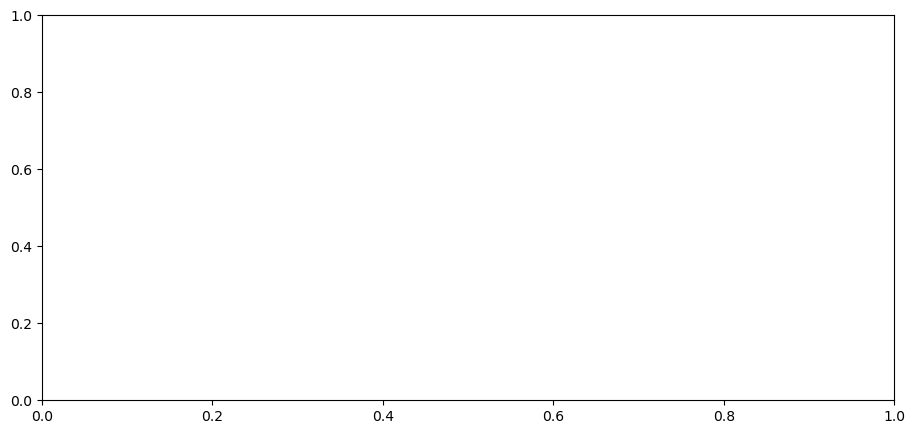

In [11]:
fig, ax = plt.subplots(figsize=(11, 5))
ax.scatter(preds_linear["ds"], preds_linear["y"], color="black", marker=".")
ax.plot(preds_linear["ds"], preds_linear["yhat"], label=f"linear, mape={mape_linear:.1%}")
ax.plot(preds_flat["ds"], preds_flat["yhat"], label=f"flat, mape={mape_flat:.1%}")
plt.xticks(rotation=60)
ax.legend();
